In [16]:
# original script: https://zenodo.org/records/4090925
# Here I want to rewrite it with biotite and expand it to use for globular protein

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union
from pathlib import Path

import numpy as np

import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.database.rcsb as rcsb
import biotite.structure.io.pdbx as pdbx
import biotite.structure.io.pdb as pdbio


# =============================
# Parameters (same meaning as your original script)
# =============================
RADIUS = 1.2   # Å (scaled by 10 in SVG)
MARGIN = 5.0   # Å (scaled by 10 in SVG)
CB_FUDGE = 1.4 # extend CA->CB vectors a bit


In [ ]:

from biotite.structure import one_letter_code

# a: acidic, b: basic, w: polar/hydrophilic, n: hydrophobic, g: glycine, s: sulfur-containing, p: proline
residue_class = {
    "ARG": "b", "HIS": "b", "LYS": "b", "ASP": "a", "GLU": "a",
    "SER": "w", "THR": "w", "ASN": "w", "GLN": "w", "CYS": "s",
    "GLY": "g", "PRO": "p", "ALA": "n", "VAL": "n", "ILE": "n",
    "LEU": "n", "MET": "s", "PHE": "n", "TYR": "n", "TRP": "n",
}

In [ ]:
def _norm_ins(x) -> str:
    if x is None:
        return ""
    s = str(x).strip()
    return "" if s == "" else s


@dataclass(frozen=True)
class ResKey:
    chain_id: str
    res_id: int
    ins_code: str


def load_structure_biotite(
    source: Union[str, Path],
    *,
    model: int = 1
) -> struc.AtomArray:
    """
    Load a structure from a local file path using Biotite.
    model is 1-based (like Biotite's get_structure(model=1)).
    """
    arr = strucio.load_structure(str(source))
    if isinstance(arr, struc.AtomArrayStack):
        idx = max(0, min(arr.stack_depth() - 1, model - 1))
        arr = arr[idx]
    return arr


def fetch_structure_from_rcsb(
    pdb_id: str,
    *,
    fmt: str = "cif",
    model: int = 1
) -> struc.AtomArray:
    """
    Fetch from RCSB and parse with Biotite.
    fmt: "cif" or "pdb"
    model: 1-based
    """
    pdb_id = pdb_id.upper()
    if fmt == "cif":
        cif = pdbx.CIFFile.read(rcsb.fetch(pdb_id, "cif"))
        arr = pdbx.get_structure(cif, model=model)
    elif fmt == "pdb":
        pdb = pdbio.PDBFile.read(rcsb.fetch(pdb_id, "pdb"))
        arr = pdbio.get_structure(pdb, model=model)
    else:
        raise ValueError("fmt must be 'cif' or 'pdb'")

    if isinstance(arr, struc.AtomArrayStack):
        arr = arr[0]
    return arr


def select_chain_amino_acids(arr: struc.AtomArray, chain_id: str) -> struc.AtomArray:
    aa_mask = struc.filter_amino_acids(arr)
    ch_mask = (arr.chain_id == chain_id)
    return arr[aa_mask & ch_mask]


def residue_keys_per_atom(aa: struc.AtomArray) -> np.ndarray:
    cats = set(aa.get_annotation_categories())
    if "ins_code" in cats:
        ins = np.array([_norm_ins(x) for x in aa.ins_code], dtype=object)
    else:
        ins = np.array([""] * len(aa), dtype=object)
    return np.array(list(zip(aa.chain_id, aa.res_id.astype(int), ins)), dtype=object)


def ordered_unique_residues(aa: struc.AtomArray) -> List[ResKey]:
    """
    Unique residues sorted by (res_id, ins_code).
    """
    keys = residue_keys_per_atom(aa).tolist()
    uniq = list({(ch, int(rid), str(ins)) for ch, rid, ins in keys})
    uniq_sorted = sorted(uniq, key=lambda t: (t[1], t[2]))
    return [ResKey(ch, rid, ins) for ch, rid, ins in uniq_sorted]


def get_atom_coord(aa: struc.AtomArray, key: ResKey, atom_name: str) -> Optional[np.ndarray]:
    cats = set(aa.get_annotation_categories())
    if "ins_code" in cats:
        ins = np.array([_norm_ins(x) for x in aa.ins_code], dtype=object)
    else:
        ins = np.array([""] * len(aa), dtype=object)

    mask = (
        (aa.chain_id == key.chain_id)
        & (aa.res_id.astype(int) == key.res_id)
        & (ins == key.ins_code)
        & (aa.atom_name == atom_name)
    )
    idx = np.where(mask)[0]
    if len(idx) == 0:
        return None
    return aa.coord[idx[0]].astype(float)


def get_res_name(aa: struc.AtomArray, key: ResKey) -> Optional[str]:
    cats = set(aa.get_annotation_categories())
    if "ins_code" in cats:
        ins = np.array([_norm_ins(x) for x in aa.ins_code], dtype=object)
    else:
        ins = np.array([""] * len(aa), dtype=object)

    mask = (
        (aa.chain_id == key.chain_id)
        & (aa.res_id.astype(int) == key.res_id)
        & (ins == key.ins_code)
    )
    idx = np.where(mask)[0]
    if len(idx) == 0:
        return None
    return str(aa.res_name[idx[0]]).strip().upper()


def build_ca_cb_maps(
    aa: struc.AtomArray,
    ordered_res: List[ResKey],
) -> tuple[
    Dict[ResKey, Tuple[float, float, str]],
    Dict[ResKey, Tuple[float, float, str]],
]:
    """
    Returns:
      ca_xy[key] = (x, y, resn)
      cb_xy[key] = (x, y, resn)   # for GLY, this is CA
    """
    ca_xy: Dict[ResKey, Tuple[float, float, str]] = {}
    cb_xy: Dict[ResKey, Tuple[float, float, str]] = {}

    for key in ordered_res:
        resn = get_res_name(aa, key)
        if resn is None:
            continue

        ca = get_atom_coord(aa, key, "CA")
        if ca is not None:
            ca_xy[key] = (float(ca[0]), float(ca[1]), resn)

        if resn == "GLY":
            if ca is not None:
                cb_xy[key] = (float(ca[0]), float(ca[1]), resn)
        else:
            cb = get_atom_coord(aa, key, "CB")
            if cb is not None:
                cb_xy[key] = (float(cb[0]), float(cb[1]), resn)

    return ca_xy, cb_xy

In [ ]:

def atom2svg_string(
    ordered_res: List[ResKey],
    ca_xy: Dict[ResKey, Tuple[float, float, str]],
    cb_xy: Dict[ResKey, Tuple[float, float, str]],
    *,
    radius: float = RADIUS,
    margin: float = MARGIN,
    cb_fudge: float = CB_FUDGE,
) -> str:
    """
    Return SVG as a string (Jupyter-friendly).
    """
    xs = [v[0] for v in ca_xy.values()]
    ys = [v[1] for v in ca_xy.values()]
    minx = -margin + float(min(xs))
    miny = -margin + float(min(ys))
    maxx =  margin + float(max(xs))
    maxy =  margin + float(max(ys))

    svg = []
    svg.append(f'''<?xml version="1.0" standalone="no"?>
<svg viewBox="0 0 {int(10*(maxx-minx))} {int(10*(maxy-miny))}" version="1.1" xmlns="http://www.w3.org/2000/svg">
<style>
 line {{stroke: black; stroke-width: 0.2px;}}
 .mainchain {{stroke-width: 0.4px;}}
 .sidechain {{stroke-width: 0.2px;}}

 circle {{stroke: black; stroke-width: 0.2px;}}
 .a {{fill: red;}}
 .b {{fill: skyblue;}}
 .w {{fill: green;}}
 .g {{fill: pink;}}
 .n {{fill: white;}}
 .s {{fill: yellow;}}
 .p {{fill: purple;}}
 .aa {{font-family: sans-serif; font-size: 1.76px; text-anchor: middle;}}
</style>
<g transform="scale(10) translate({-minx:.6f}, {-miny:.6f})">
''')

    # Main chain (connect consecutive residues in ordered_res if both have CA)
    svg.append("\n")
    for i in range(1, len(ordered_res)):
        cur = ordered_res[i]
        prev = ordered_res[i - 1]
        if cur not in ca_xy or prev not in ca_xy:
            continue
        x1, y1, _ = ca_xy[cur]
        x2, y2, _ = ca_xy[prev]
        svg.append(
            f' <line x1="{x1:.6f}" y1="{y1:.6f}" x2="{x2:.6f}" y2="{y2:.6f}" class="mainchain" />\n'
        )

    # Side chains
    svg.append("\n")
    for key in ordered_res:
        if key not in cb_xy:
            continue

        cbx, cby, resn = cb_xy[key]
        if resn not in residue_class:
            continue

        if resn == "GLY":
            posx, posy = cbx, cby
        else:
            if key not in ca_xy:
                continue
            cax, cay, _ = ca_xy[key]
            posx = cb_fudge * cbx + (1 - cb_fudge) * cax
            posy = cb_fudge * cby + (1 - cb_fudge) * cay
            svg.append(
                f' <line x1="{posx:.6f}" y1="{posy:.6f}" x2="{cax:.6f}" y2="{cay:.6f}" class="sidechain" />\n'
            )

        cls = residue_class[resn]
        aa1 = one_letter_code.get(resn, "X")
        svg.append(f' <circle cx="{posx:.6f}" cy="{posy:.6f}" r="{radius:.6f}" class="{cls}" />\n')
        svg.append(f' <text x="{posx:.6f}" y="{(posy + radius/2.0):.6f}" class="aa">{aa1}</text>\n\n')

    svg.append("</g>\n</svg>\n")
    return "".join(svg)


def save_svg(svg_text: str, out_path: Union[str, Path]) -> None:
    out_path = Path(out_path)
    out_path.write_text(svg_text, encoding="utf-8")


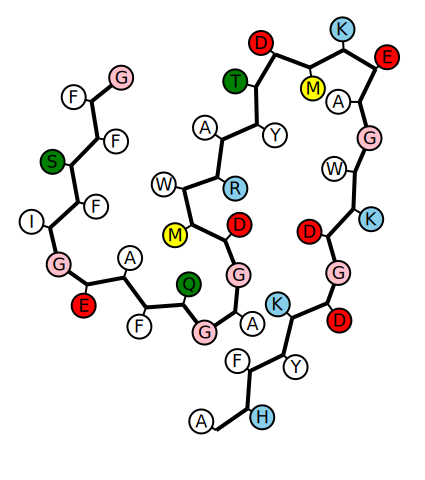

In [18]:
input_type = "6ZCG"  # or "6ZCG.pdb" or "6ZCG.cif" or "6ZCG"
chain_id = "A"
model = 1

if input_type.endswith(".pdb") or input_type.endswith(".cif"):
    arr = load_structure_biotite(input_path, model=model)
else:
    arr = fetch_structure_from_rcsb(pdb_id, fmt=fmt, model=model)

aa = select_chain_amino_acids(arr, chain_id)
ordered_res = ordered_unique_residues(aa)
ca_xy, cb_xy = build_ca_cb_maps(aa, ordered_res)

svg_text = atom2svg_string(ordered_res, ca_xy, cb_xy)

# show in notebook
from IPython.display import SVG, display
display(SVG(svg_text))

# optionally save
save_svg(svg_text, "output.svg")
